In [54]:
from obspy import read
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import numpy as np

In [55]:
# სეისმური სადგურის მონაცემების მისაღები სერვერი
FDSN_CLIENT = Client("http://192.168.11.250:8080")
# მიწისძვრის დრო, რომელიც გადაეცემა როგორც არგუმენტი
ORIGIN_TIME = UTCDateTime("2025-04-06T02:03:27.430")
START_TIME = ORIGIN_TIME - 120  # 120 წამით ადრე
END_TIME = ORIGIN_TIME + 180  # 180 წამით გვიან

3 Trace(s) in Stream:
GO.ALIA.10.HNE | 2025-04-06T02:01:27.430000Z - 2025-04-06T02:06:27.430000Z | 200.0 Hz, 60001 samples
GO.ALIA.10.HNN | 2025-04-06T02:01:27.430000Z - 2025-04-06T02:06:27.430000Z | 200.0 Hz, 60001 samples
GO.ALIA.10.HNZ | 2025-04-06T02:01:27.430000Z - 2025-04-06T02:06:27.430000Z | 200.0 Hz, 60001 samples

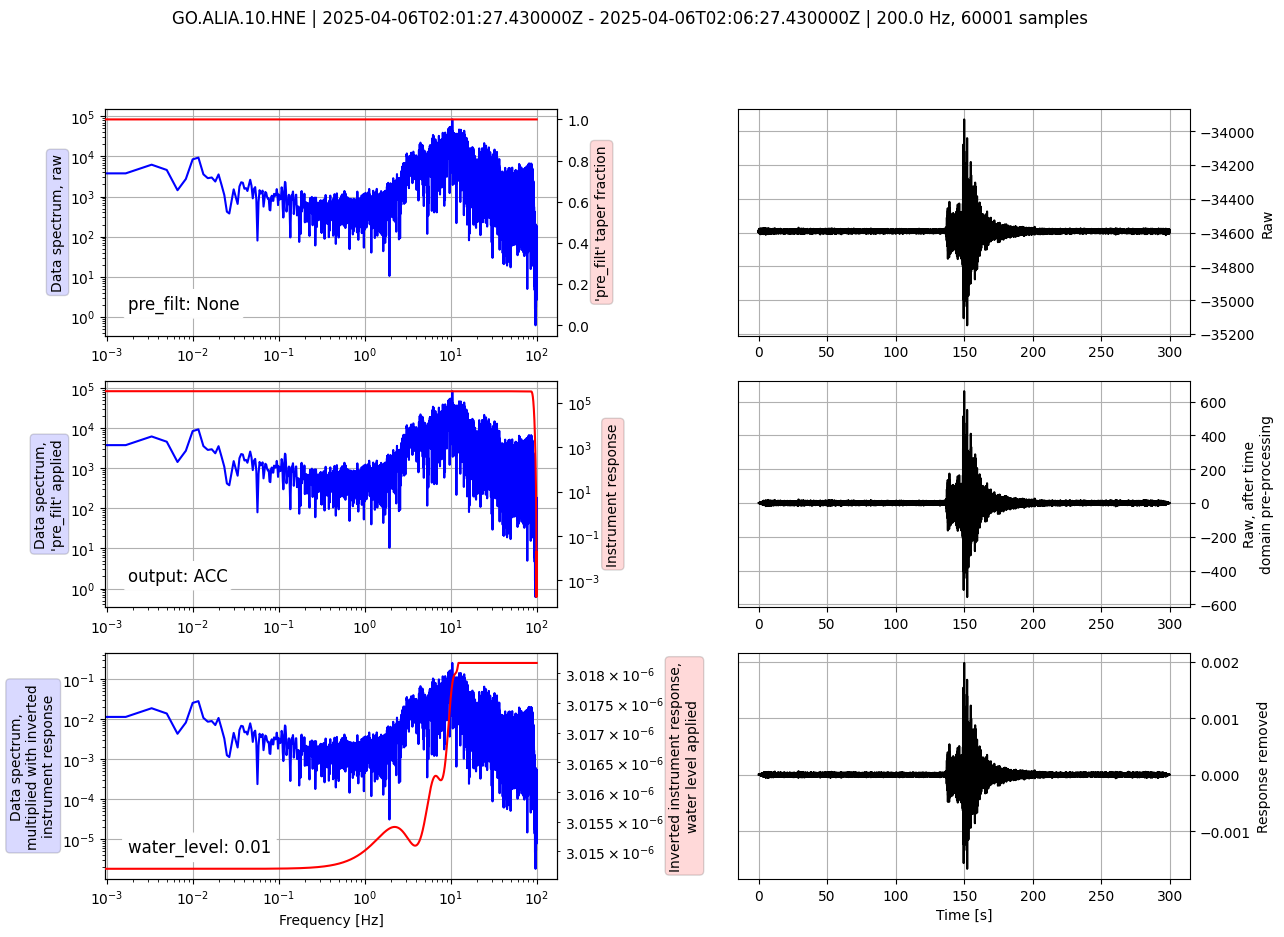

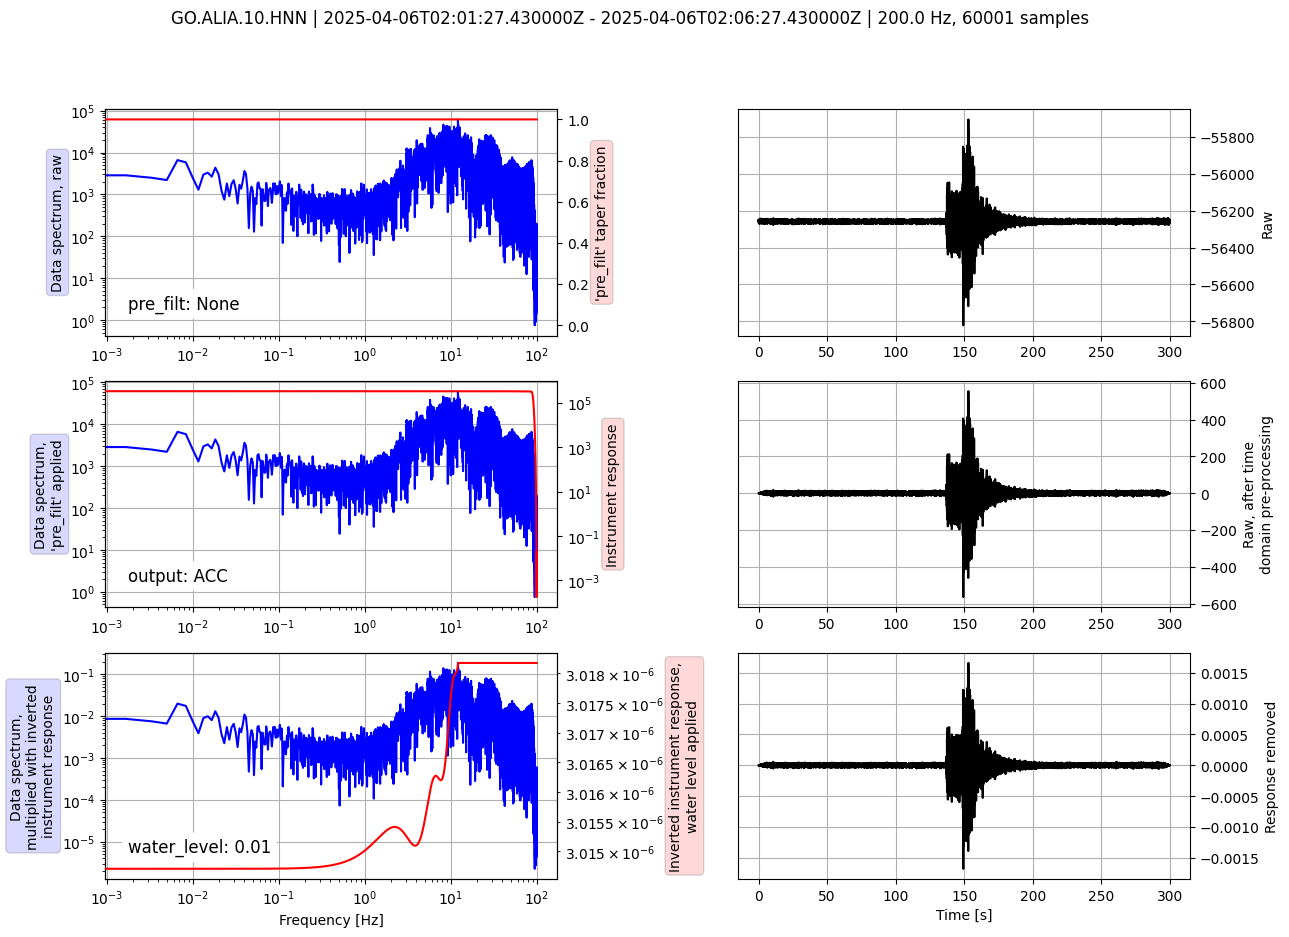

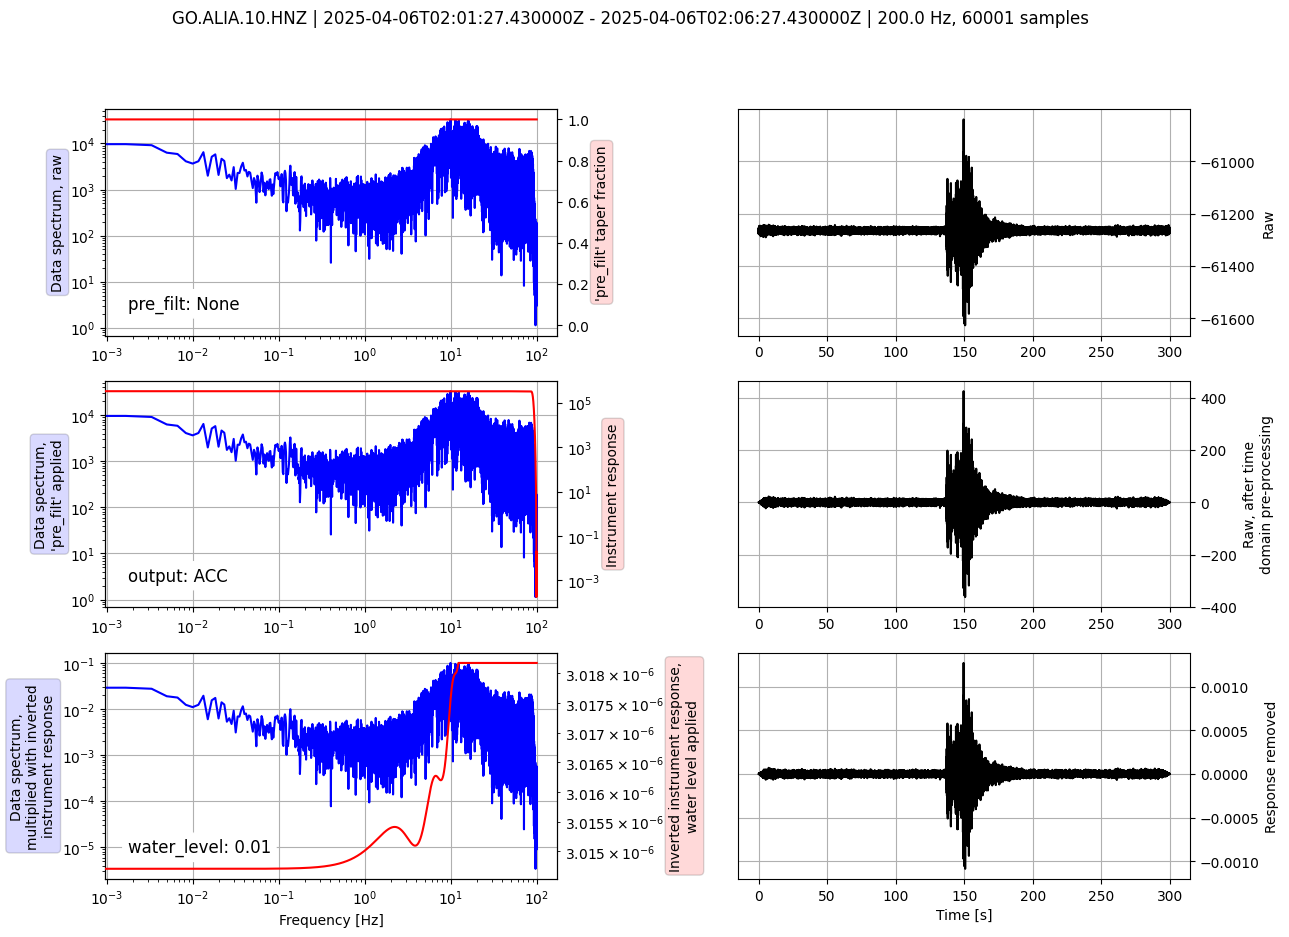

In [59]:
station = 'ALIA'
channel = 'HN*'
pre_filt = (0.004, 0.007, 5, 10)

st_inventory = FDSN_CLIENT.get_stations(network='GO', station=station, location='*', channel=channel, starttime=START_TIME, endtime=END_TIME, level="response")

# ვიღებთ ტალღის ფორმებს
stream = FDSN_CLIENT.get_waveforms('GO', station, '*', channel, START_TIME, END_TIME)
# ვშლით ინსტრუმენტულ პასუხს (response) და ვცვლით ერთეულს
# tr = stream[0]
stream.remove_response(inventory=st_inventory, output="ACC", plot=True, zero_mean=True, water_level=0.01)

In [57]:
for tr in stream:
    g_acc = tr.data / 9.81  # აჩქარების გადაყვანა g ერთეულში
    max_g = np.max(np.abs(g_acc))
    print(f'{tr.stats.channel} : {max_g}')

HNE : 0.00020401842124125497
HNN : 0.0001700480656640079
HNZ : 0.00015102662010607124
